1.7.1 Perfectly Matched Layer (PML)
====


The use of (Perfectly Matched Layer) PML is a standard technique to numerically solve for outgoing waves in unbounded domains. Although scattering problems are posed in unbounded domains,  by bounding the scatterer and any inhomogeneities within a PML, one is able to truncate to a bounded computational domain. In this tutorial we see how to use PML for 
- source problems, and 
- eigenvalue problems (resonances).

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt

### Source problem

Consider the problem of finding $u$ satisfying 

$$
-\Delta u - \omega^2 u = f \qquad \text{ in } \mathbb{R}^2
$$

together with the Sommerfeld (outgoing) radiation condition at infinity

$$
\lim_{r \to \infty} r^{1/2}
\bigg( 
\frac{\partial u }{ \partial r} - i \omega u 
\bigg) = 0
$$

where $r$ is the radial coordinate.  Below, we set an $f$ that represents a time-harmonic pulse that is  almost zero except for a small region.

We create a geometry which is divided into an `inner` disk and and an outer 
annulus called `pmlregion`.

In [2]:
outer = Circle((0,0), 1.4).Face()
outer.edges.name = 'outerbnd'
inner = Circle((0,0), 1).Face()
inner.edges.name = 'innerbnd'
inner.faces.name ='inner'
pmlregion = outer - inner
pmlregion.faces.name = 'pmlregion'
geo = OCCGeometry(Glue([inner, pmlregion]), dim=2)

mesh = Mesh(geo.GenerateMesh (maxh=0.1))
mesh.Curve(3)

f = exp(-20**2*((x-0.3)*(x-0.3)+y*y))
Draw(f, mesh);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…


The PML facility in NGSolve implements a complex coordinate transformation on a given mesh region (which in  this example is  `pmlregion`). When this complex variable change is applied to the outgoing solution in the PML region,  it becomes a a function that decays exponentially as $r \to \infty$, allowing us to truncate the unbounded domain.

With the following single line, we tell NGSolve to turn on this coordinate transformation. 

In [3]:
mesh.SetPML(pml.Radial(rad=1,alpha=1j,origin=(0,0)), "pmlregion")

Then a  radial PML is set in the exterior of a disk 
centered at `origin`  of radius `rad`. In addition to 
`origin` and `rad`, the keyword argument `alpha` may be used to set
the PML strength, which determines the rate of increase in the imaginary
part of the coordinate map as radius increases.

Having set the PML, the rest of the code now  looks very much like that  in [Unit 1.7](../unit-1.7-helmholtz/helmholtz.ipynb):

In [4]:
fes = H1(mesh, order=4, complex=True)
u = fes.TrialFunction()
v = fes.TestFunction()

omega = 10

a = BilinearForm(fes)
a += grad(u)*grad(v)*dx - omega**2*u*v*dx
a += -1j*omega*u*v*ds("outerbnd")  #？ 还要加这一个？
a.Assemble()

b = LinearForm(f * v * dx).Assemble()

gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse() * b.vec
Draw(gfu);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

Note that above we have kept the same Robin boundary conditions as in [Unit 1.7](../unit-1.7-helmholtz/helmholtz.ipynb).
(Since the solution exponentially decays within PML, it is also common practice to put zero Dirichlet boundary conditions at the outer edge of the PML, an option that is also easily implementable in NGSolve using the `dirichlet` flag.)



### Eigenvalue problem

PML can also be used to compute resonances on unbounded domains. Resonances of a scatterer $S$ are outgoing waves $u$ satisfying the homogeneous Helmholtz equation

$$
\Delta u + \omega^2 u = 0
 \qquad \text{ in } \mathbb{R}^2 \setminus S,
$$

i.e., $u$ is an eigenfunction of $-\Delta$ associated to eigenvalue $\lambda :=\omega^2.$

We truncate this unbounded-domain eigenproblem to a bounded-domain eigenproblem using PML. The following example computes the resonances of a cavity opening on one side into free space.

In [5]:
shroom = MoveTo(-2, 0).Line(1.8).Rotate(-90).Line(0.8).Rotate(90).Line(0.4). \
    Rotate(90).Line(0.8).Rotate(-90).Line(1.8).Rotate(90).Arc(2, 180).Face()
circ = Circle((0, 0), 1).Face()
pmlregion = shroom - circ
pmlregion.faces.name = 'pml'
air = shroom * circ
air.faces.name = 'air'
shape = Glue([air, pmlregion])
geo = OCCGeometry(shape, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.1))
mesh.Curve(5)
Draw(mesh);

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

The top edge of the rectangular cavity opens into air, which is included in the computational domain as a semicircular region (neglecting backward propagating waves), while the remaining edges of the cavity are isolated from rest of space by perfect reflecting boundary conditions.

In [6]:
mesh.SetPML(pml.Radial(rad=1, alpha=1j, origin=(0,0)), "pml")

We now make the complex symmetric system with PML incorporated.

In [7]:
fes = H1(mesh, order=4, complex=True, dirichlet="dir")

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(grad(u)*grad(v)*dx).Assemble()
m = BilinearForm(u*v*dx).Assemble();

For solving the eigenproblem, we use an Arnoldi eigensolver, to which a `GridFunction` with many vectors (allocated via keyword argument `multidim`) is input, together with `a` and `b`. A `shift` argument to `ArnoldiSolver` indicates the approximate location of expected eigenvalues.

In [8]:
u = GridFunction(fes, multidim=50, name='resonances')

with TaskManager():
    lam = ArnoldiSolver(a.mat, m.mat, fes.FreeDofs(), 
                        list(u.vecs), shift=400)
Draw(u);

In [ ]:
print ("lam: ", lam)

lam:   (411.452,-18.9533)
 (328.358,-10.2341)
 (330.435,-42.2536)
 (473.218,-70.5334)
 (521.395,-38.2833)
 (276.338,-3.20974)
 (401.266,-125.358)
 (558.506,-0.360557)
 (250.018,-0.389488)
 (585.434,-3.44622)
 (353.556,-136.644)
 (478.229,-136.213)
 (258.035,-81.7662)
 (220.608,-23.8056)
 (640.642,-8.60198)
 (556.593,-131.257)
 (423.466,-187.308)
 (447.573,-159.271)
 (655.997,-57.071)
 (548.06,-168.064)
 (265.383,-153.772)
 (637.467,-114.357)
 (719.754,-17.9704)
 (641.156,-132.437)
 (310.663,-199.459)
 (140.873,-11.4155)
 (469.536,-227.129)
 (419.762,-241.027)
 (367.359,-240.1)
 (338.207,-232.094)
 (356.883,-240.519)
 (345.094,-240.146)
 (378.284,-249.892)
 (399.446,-250.051)
 (150.193,-42.9505)
 (407.979,-251.836)
 (323.217,-240.709)
 (304.872,-229.841)
 (294.859,-232.073)
 (435.696,-260.014)
 (456.077,-252.814)
 (259.615,-220.852)
 (474.737,-248.14)
 (276.629,-230.054)
 (484.132,-251.608)
 (504.956,-246.831)
 (247.639,-215.412)
 (522.493,-251.674)
 (231.023,-208.768)
 (540.969,-247.53

The more "confined" modes have resonance values $\omega$ that are closer to the real axis. Here are the computed $\omega$-values plotted in the complex plane.

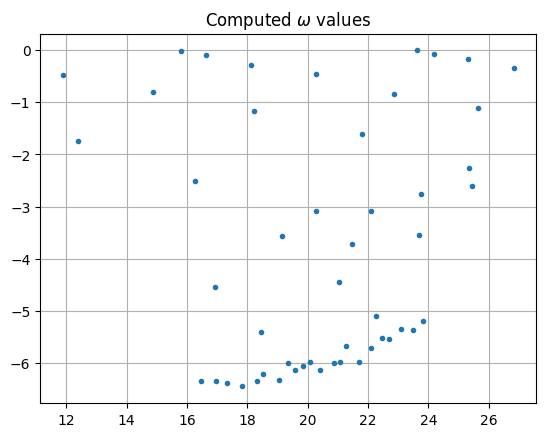

In [ ]:
lamr = [sqrt(l).real for l in lam]
lami = [sqrt(l).imag for l in lam]
plt.plot(lamr, lami, ".")
plt.grid(True)
plt.title('Computed $\omega$ values')
plt.show()